# Singapore Government Tender Analysis - Business Questions & Strategic Insights

This notebook implements the two core machine learning techniques outlined in our documentation:

1. **Supplier Portfolio Optimization** using K-Means clustering
2. **Predictive Commercial Risk Assessment** using Random Forest classification

## Analysis Framework

### Dataset Context
- **Records**: 18,021 tender transactions across 111 government agencies
- **Suppliers**: 6,083 unique suppliers participating in government procurement
- **Award Success Rate**: 96.1% of tenders result in successful awards
- **Value Range**: S$0 to S$1.49 billion in contract values

### Business Questions Addressed
1. How do we explore the data and discover patterns/segmentation for better SME growth and risk management?
2. Can we predict which tenders require commercial review due to unusual award amounts?

### Machine Learning Approach
- **Supplier Clustering**: Unsupervised learning to identify 5 strategic supplier segments
- **Risk Prediction**: Supervised learning to flag unusual award patterns for commercial review

In [18]:
# Import required libraries
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import yaml
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                           confusion_matrix, classification_report)
from scipy import stats

# Add src directory to path
sys.path.append(str(Path().absolute().parent / 'src'))

# Set display options
pd.set_option('display.max_columns', 50)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:,.2f}'.format)

# Load configuration
config_path = Path().absolute().parent / 'config.yaml'
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

# Load processed data from Outputs directory
output_dir = Path().absolute().parent / 'Outputs'
processed_data_path = output_dir / 'tender_data_processed.csv'

if processed_data_path.exists():
    df = pd.read_csv(processed_data_path)
    print(f"Processed data loaded: {df.shape}")
else:
    # Run preprocessing if not available
    print("Processed data not found, running preprocessing...")
    from src.preprocessing import preprocess_pipeline
    preprocessor, df = preprocess_pipeline()
    print(f"Data preprocessed: {df.shape}")

# Convert date columns
if 'award_date' in df.columns:
    df['award_date'] = pd.to_datetime(df['award_date'], errors='coerce')

print(f"\nDataset Overview:")
print(f"Total Records: {len(df):,}")
print(f"Unique Agencies: {df['agency'].nunique()}")
print(f"Unique Suppliers: {df['supplier_name'].nunique()}")
print(f"Award Success Rate: {(df['awarded_amt'] > 0).sum() / len(df) * 100:.1f}%")

if df['awarded_amt'].sum() > 0:
    print(f"Total Award Value: S${df['awarded_amt'].sum():,.0f}")
    print(f"Average Award: S${df[df['awarded_amt'] > 0]['awarded_amt'].mean():,.0f}")

Processed data loaded: (11915, 24)

Dataset Overview:
Total Records: 11,915
Unique Agencies: 111
Unique Suppliers: 4134
Award Success Rate: 94.1%
Total Award Value: S$102,017,705,026
Average Award: S$9,095,730


## 2. Supplier Portfolio Optimization Analysis

**Business Objective**: Identify strategic supplier segments to balance cost efficiency, risk management, and SME development while maintaining competitive markets.

### Methodology
- **K-Means clustering** with 5 segments to capture supplier diversity
- **Business-relevant features**: total awards, agency diversity, contract consistency, award variability
- **Strategic profiling**: Classify suppliers by scale, market reach, and value proposition

### Expected Insights
1. Market concentration analysis and risk assessment
2. SME participation rates and development opportunities  
3. Multi-agency supplier identification for strategic partnerships
4. Supplier diversification recommendations for high-concentration agencies

=== SUPPLIER PORTFOLIO OPTIMIZATION ANALYSIS ===
Active suppliers for clustering: 4133

--- SUPPLIER CLUSTER PROFILING ---
         count  total_awards_sum  total_awards_mean  avg_award_mean  \
cluster                                                               
0         3598 21,576,161,320.71       5,996,709.65    3,511,699.64   
1           43  5,367,511,534.76     124,825,849.65    3,665,006.08   
2           56 47,485,034,903.85     847,947,051.85  200,539,466.89   
3           16 14,393,496,305.10     899,593,519.07  751,675,187.45   
4          420 13,195,500,961.68      31,417,859.43    3,830,882.16   

         num_contracts_mean  num_agencies_mean  std_awards_mean  
cluster                                                          
0                      1.65               1.32     2,639,417.42  
1                     34.44              17.79     5,784,799.51  
2                      4.70               2.16   138,700,135.93  
3                      1.31               1.00   

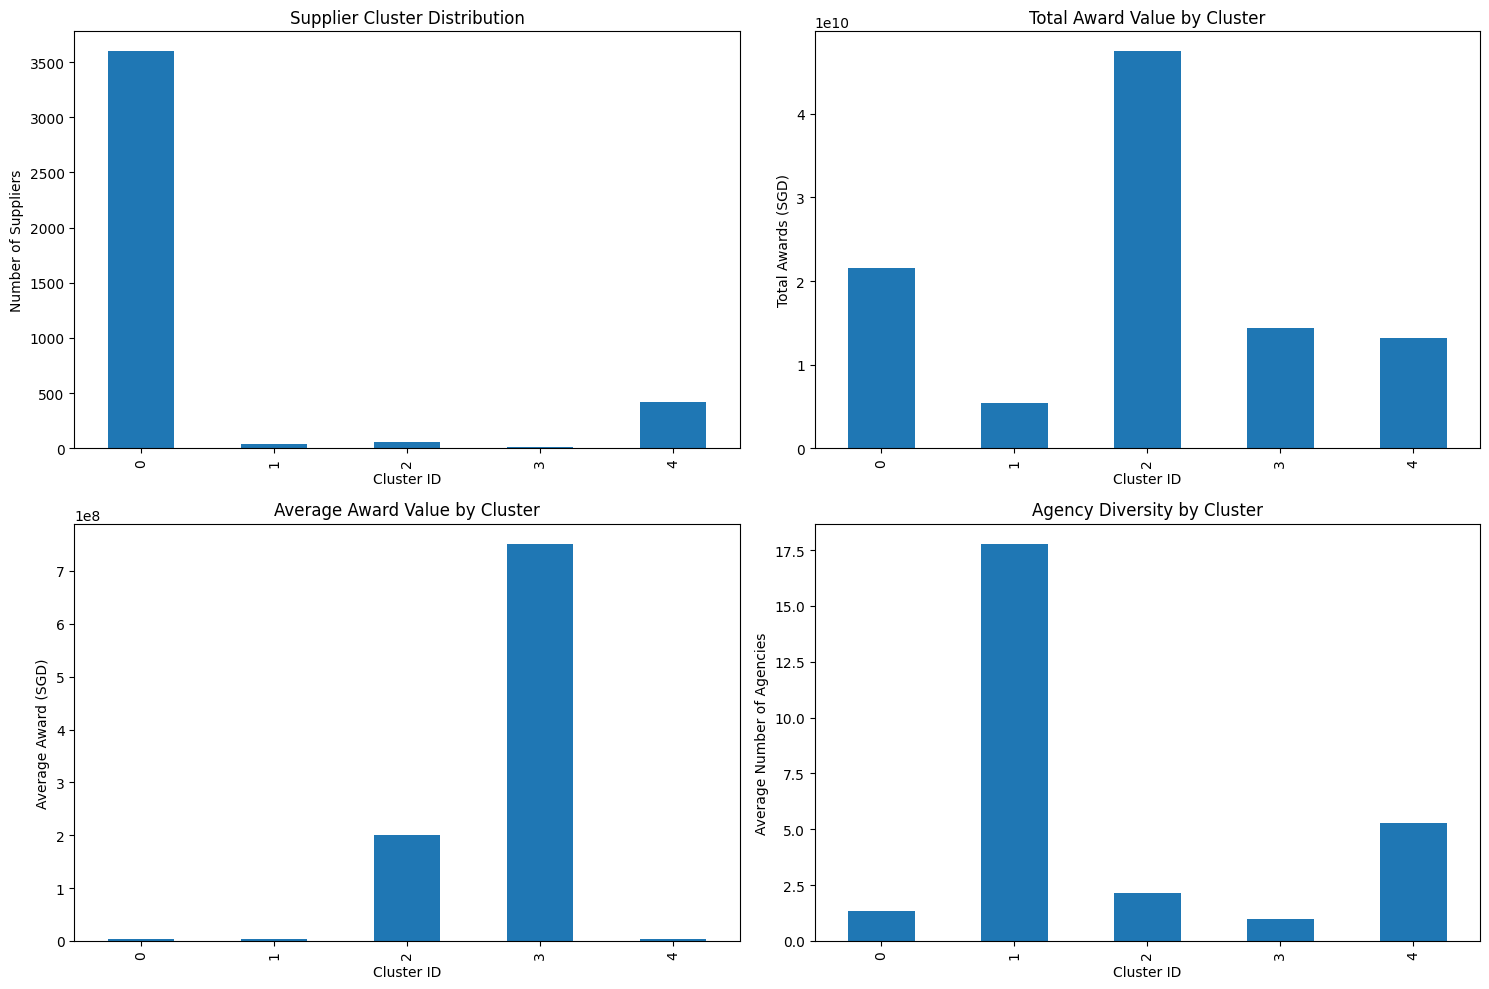

In [31]:
def perform_supplier_clustering_analysis(df):
    """
    Perform supplier clustering analysis to identify strategic segments
    """
    print("=== SUPPLIER PORTFOLIO OPTIMIZATION ANALYSIS ===")
    
    # Prepare supplier aggregation data
    supplier_analysis = df.groupby('supplier_name').agg({
        'awarded_amt': ['sum', 'mean', 'count', 'std'],
        'agency': 'nunique',
        'tender_detail_status': 'count'
    }).round(2)
    
    # Flatten column names
    supplier_analysis.columns = ['total_awards', 'avg_award', 'num_contracts', 'std_awards', 'num_agencies', 'total_tenders']
    
    # Filter to active suppliers (those with awards)
    active_suppliers = supplier_analysis[supplier_analysis['total_awards'] > 0].copy()
    print(f"Active suppliers for clustering: {len(active_suppliers)}")
    
    # Prepare features for clustering
    clustering_features = ['total_awards', 'avg_award', 'num_contracts', 'num_agencies', 'std_awards']
    X_supplier = active_suppliers[clustering_features].fillna(0)
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_supplier)
    
    # Apply K-Means clustering (5 segments as per documentation)
    kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    kmeans_alt = KMeans(n_clusters=4, random_state=42, n_init=10)
    cluster_labels_alt = kmeans_alt.fit_predict(X_scaled)
    
    # Add cluster labels to supplier data
    active_suppliers['cluster'] = cluster_labels
    active_suppliers['alt_cluster'] = cluster_labels_alt
    
    # Analyze clusters
    cluster_analysis = active_suppliers.groupby('cluster').agg({
        'total_awards': ['count', 'sum', 'mean'],
        'avg_award': 'mean',
        'num_contracts': 'mean',
        'num_agencies': 'mean',
        'std_awards': 'mean'
    }).round(2)
    
    alt_cluster_analysis = active_suppliers.groupby('alt_cluster').agg({
		'total_awards': ['count', 'sum', 'mean'],
		'avg_award': 'mean',
		'num_contracts': 'mean',
		'num_agencies': 'mean',
		'std_awards': 'mean'
	}).round(2)
    
    alt_cluster_analysis.columns = ['count', 'total_awards_sum', 'total_awards_mean', 'avg_award_mean', 
							 'num_contracts_mean', 'num_agencies_mean', 'std_awards_mean']
    
    cluster_analysis.columns = ['count', 'total_awards_sum', 'total_awards_mean', 'avg_award_mean', 
                             'num_contracts_mean', 'num_agencies_mean', 'std_awards_mean']
    
    print(f"\n--- SUPPLIER CLUSTER PROFILING ---\n{cluster_analysis}")
    print(f"\n\n--- ALTERNATIVE SUPPLIER CLUSTER PROFILING ---\n{alt_cluster_analysis}")
    
    # Create strategic profiles for each cluster
    def create_supplier_profile(cluster_id, cluster_data):
        total_awards = cluster_data['total_awards_sum'].iloc[0]
        avg_award = cluster_data['avg_award_mean'].iloc[0]
        num_agencies = cluster_data['num_agencies_mean'].iloc[0]
        count = cluster_data['count'].iloc[0]
        
        # Determine scale
        if total_awards > cluster_analysis['total_awards_sum'].quantile(0.8):
            scale = "Large Scale"
        elif total_awards > cluster_analysis['total_awards_sum'].quantile(0.4):
            scale = "Medium Scale"
        else:
            scale = "Small Scale"
        
        # Determine reach
        if num_agencies > cluster_analysis['num_agencies_mean'].quantile(0.7):
            reach = "Broad Reach"
        elif num_agencies > cluster_analysis['num_agencies_mean'].quantile(0.3):
            reach = "Moderate Reach"
        else:
            reach = "Specialized"
        
        # Determine value profile
        if avg_award > cluster_analysis['avg_award_mean'].quantile(0.7):
            value = "High Value"
        elif avg_award > cluster_analysis['avg_award_mean'].quantile(0.3):
            value = "Medium Value"
        else:
            value = "Low Value"
        
        return f"{scale} {value} {reach}"
    
    print("\n--- STRATEGIC SUPPLIER SEGMENTS ---")
    segment_profiles = {}
    
    for cluster_id in sorted(active_suppliers['cluster'].unique()):
        cluster_data = cluster_analysis.loc[[cluster_id]]
        profile = create_supplier_profile(cluster_id, cluster_data)
        count = len(active_suppliers[active_suppliers['cluster'] == cluster_id])
        percentage = count / len(active_suppliers) * 100
        
        segment_profiles[cluster_id] = {
            'profile': profile,
            'count': count,
            'percentage': percentage
        }
        
        print(f"Cluster {cluster_id}: {profile} ({count} suppliers, {percentage:.1f}%)")
        
        # Show example suppliers
        cluster_suppliers = active_suppliers[active_suppliers['cluster'] == cluster_id]
        examples = cluster_suppliers.nlargest(3, 'total_awards').index.tolist()[:3]
        print(f"  Examples: {', '.join(examples)}")
        print()
    
    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # 1. Cluster distribution
    cluster_counts = active_suppliers['cluster'].value_counts().sort_index()
    cluster_counts.plot(kind='bar', ax=axes[0, 0])
    axes[0, 0].set_title('Supplier Cluster Distribution')
    axes[0, 0].set_xlabel('Cluster ID')
    axes[0, 0].set_ylabel('Number of Suppliers')
    
    # 2. Total awards by cluster
    cluster_totals = active_suppliers.groupby('cluster')['total_awards'].sum()
    cluster_totals.plot(kind='bar', ax=axes[0, 1])
    axes[0, 1].set_title('Total Award Value by Cluster')
    axes[0, 1].set_xlabel('Cluster ID')
    axes[0, 1].set_ylabel('Total Awards (SGD)')
    
    # 3. Average award by cluster
    cluster_avg = active_suppliers.groupby('cluster')['avg_award'].mean()
    cluster_avg.plot(kind='bar', ax=axes[1, 0])
    axes[1, 0].set_title('Average Award Value by Cluster')
    axes[1, 0].set_xlabel('Cluster ID')
    axes[1, 0].set_ylabel('Average Award (SGD)')
    
    # 4. Agency diversity by cluster
    cluster_diversity = active_suppliers.groupby('cluster')['num_agencies'].mean()
    cluster_diversity.plot(kind='bar', ax=axes[1, 1])
    axes[1, 1].set_title('Agency Diversity by Cluster')
    axes[1, 1].set_xlabel('Cluster ID')
    axes[1, 1].set_ylabel('Average Number of Agencies')
    
    plt.tight_layout()
    plt.show()
    
    return active_suppliers, cluster_analysis, segment_profiles, kmeans, scaler

# Perform supplier clustering analysis
suppliers_clustered, supplier_cluster_analysis, supplier_segments, kmeans_model, scaler = perform_supplier_clustering_analysis(df)

In [32]:
suppliers_clustered['cluster'].value_counts().sort_index()

cluster
0    3598
1      43
2      56
3      16
4     420
Name: count, dtype: int64

In [34]:
#what if we clustered with k=4 instead?
# suppliers_clustered['alt_cluster'].value_counts().sort_index()

In [20]:
### Supplier Portfolio Business Insights

# The clustering analysis reveals strategic supplier segments that inform procurement optimization strategies.

def generate_supplier_portfolio_insights(suppliers_clustered, supplier_segments):
    """
    Generate business insights for supplier portfolio optimization
    """
    print("=== SUPPLIER PORTFOLIO OPTIMIZATION INSIGHTS ===")
    
    # Overall market structure
    total_suppliers = len(suppliers_clustered)
    total_value = suppliers_clustered['total_awards'].sum()
    
    print(f"\nMARKET OVERVIEW:")
    print(f"• Total Active Suppliers: {total_suppliers:,}")
    print(f"• Total Market Value: S${total_value:,.0f}")
    print(f"• Average Supplier Value: S${total_value/total_suppliers:,.0f}")
    
    # SME analysis (assuming low-value suppliers are SMEs)
    sme_threshold = suppliers_clustered['total_awards'].quantile(0.5)  # Median as SME threshold
    sme_count = len(suppliers_clustered[suppliers_clustered['total_awards'] <= sme_threshold])
    sme_percentage = sme_count / total_suppliers * 100
    
    print(f"\nSME PARTICIPATION:")
    print(f"• SME Suppliers (below median): {sme_count} ({sme_percentage:.1f}%)")
    print(f"• Non-SME Suppliers: {total_suppliers - sme_count} ({100-sme_percentage:.1f}%)")
    
    # Concentration analysis
    top_10_suppliers = suppliers_clustered.nlargest(10, 'total_awards')
    top_10_value = top_10_suppliers['total_awards'].sum()
    top_10_percentage = top_10_value / total_value * 100
    
    print(f"\nMARKET CONCENTRATION:")
    print(f"• Top 10 Suppliers Value: S${top_10_value:,.0f} ({top_10_percentage:.1f}% of total)")
    print(f"• Remaining Suppliers Value: S${total_value - top_10_value:,.0f} ({100-top_10_percentage:.1f}%)")
    
    # Multi-agency supplier analysis
    multi_agency_suppliers = suppliers_clustered[suppliers_clustered['num_agencies'] > 1]
    multi_agency_count = len(multi_agency_suppliers)
    multi_agency_percentage = multi_agency_count / total_suppliers * 100
    
    print(f"\nMULTI-AGENCY PRESENCE:")
    print(f"• Multi-Agency Suppliers: {multi_agency_count} ({multi_agency_percentage:.1f}%)")
    print(f"• Single-Agency Suppliers: {total_suppliers - multi_agency_count} ({100-multi_agency_percentage:.1f}%)")
    
    # Segment-specific insights
    print(f"\nSTRATEGIC SEGMENT INSIGHTS:")
    
    for cluster_id, segment_info in supplier_segments.items():
        cluster_data = suppliers_clustered[suppliers_clustered['cluster'] == cluster_id]
        segment_value = cluster_data['total_awards'].sum()
        segment_percentage = segment_value / total_value * 100
        
        print(f"\n{segment_info['profile']}:")
        print(f"  • Market Share: {segment_percentage:.1f}% of total value")
        print(f"  • Supplier Count: {segment_info['count']} ({segment_info['percentage']:.1f}% of suppliers)")
        print(f"  • Total Value: S${segment_value:,.0f}")
        
        # Business recommendations
        if "Large Scale" in segment_info['profile'] and "Broad Reach" in segment_info['profile']:
            print(f"  • STRATEGIC PARTNERSHIP CANDIDATES")
            print(f"  • Develop framework agreements and long-term partnerships")
        elif "Specialized" in segment_info['profile']:
            print(f"  • NICHE EXPERTISE PROVIDERS")
            print(f"  • Protect category expertise and ensure knowledge transfer")
        elif "Small Scale" in segment_info['profile']:
            print(f"  • SME DEVELOPMENT TARGETS")
            print(f"  • Create capability building programs and mentorship")
    
    # Risk assessment
    print(f"\nRISK ASSESSMENT:")
    
    # Concentration risk
    if top_10_percentage > 50:
        print(f"• HIGH CONCENTRATION RISK: Top 10 suppliers control {top_10_percentage:.1f}% of market")
    else:
        print(f"• MODERATE CONCENTRATION: Top 10 suppliers control {top_10_percentage:.1f}% of market")
    
    # Dependency risk
    single_agency_percentage = (total_suppliers - multi_agency_count) / total_suppliers * 100
    if single_agency_percentage > 70:
        print(f"• HIGH DEPENDENCY RISK: {single_agency_percentage:.1f}% of suppliers are single-agency dependent")
    
    return {
        'total_suppliers': total_suppliers,
        'total_value': total_value,
        'sme_percentage': sme_percentage,
        'top_10_concentration': top_10_percentage,
        'multi_agency_percentage': multi_agency_percentage
    }

# Generate supplier portfolio insights
supplier_insights = generate_supplier_portfolio_insights(suppliers_clustered, supplier_segments)

=== SUPPLIER PORTFOLIO OPTIMIZATION INSIGHTS ===

MARKET OVERVIEW:
• Total Active Suppliers: 4,133
• Total Market Value: S$102,017,705,026
• Average Supplier Value: S$24,683,693

SME PARTICIPATION:
• SME Suppliers (below median): 2067 (50.0%)
• Non-SME Suppliers: 2066 (50.0%)

MARKET CONCENTRATION:
• Top 10 Suppliers Value: S$18,068,355,165 (17.7% of total)
• Remaining Suppliers Value: S$83,949,349,861 (82.3%)

MULTI-AGENCY PRESENCE:
• Multi-Agency Suppliers: 1376 (33.3%)
• Single-Agency Suppliers: 2757 (66.7%)

STRATEGIC SEGMENT INSIGHTS:

Medium Scale Low Value Specialized:
  • Market Share: 21.1% of total value
  • Supplier Count: 3598 (87.1% of suppliers)
  • Total Value: S$21,576,161,321
  • NICHE EXPERTISE PROVIDERS
  • Protect category expertise and ensure knowledge transfer

Small Scale Low Value Broad Reach:
  • Market Share: 5.3% of total value
  • Supplier Count: 43 (1.0% of suppliers)
  • Total Value: S$5,367,511,535
  • SME DEVELOPMENT TARGETS
  • Create capability buildin

## 3. Commercial Risk Assessment Analysis

**Business Objective**: Develop a predictive model to identify tenders requiring commercial review due to unusual award amounts, enabling proactive risk management and resource allocation.

### Critical Consideration: Overfitting Prevention
Random Forest models are prone to overfitting, especially with high-dimensional data. To ensure realistic performance:
- **Temporal validation**: Use earlier years for training, later years for testing
- **Constrained model complexity**: Limit tree depth and require minimum samples per leaf
- **Feature selection**: Focus on business-relevant features that generalize well
- **Regularization**: Use balanced class weights to handle imbalanced data

### Risk Analysis Strategy
- **Predict risk**: Using the trained model, predict risk prob%
- **Statistical outlier detection**: Simple flagging for awards exceeding 3 standard deviations from agency means (contextualizes risk by agency)
- **Agency-specific baselines**: Account for different spending patterns across agencies
- **Business context**: High-value awards naturally warrant additional scrutiny

### Business Insights: Supplier Portfolio Optimization

In [4]:
def generate_supplier_portfolio_insights(suppliers_clustered, supplier_segments):
    """
    Generate business insights for supplier portfolio optimization
    """
    print("=== SUPPLIER PORTFOLIO OPTIMIZATION INSIGHTS ===")
    
    # Overall market structure
    total_suppliers = len(suppliers_clustered)
    total_value = suppliers_clustered['total_awards'].sum()
    
    print(f"\nMARKET OVERVIEW:")
    print(f"• Total Active Suppliers: {total_suppliers:,}")
    print(f"• Total Market Value: S${total_value:,.0f}")
    print(f"• Average Supplier Value: S${total_value/total_suppliers:,.0f}")
    
    # SME analysis (assuming low-value suppliers are SMEs)
    sme_threshold = suppliers_clustered['total_awards'].quantile(0.5)  # Median as SME threshold
    sme_count = len(suppliers_clustered[suppliers_clustered['total_awards'] <= sme_threshold])
    sme_percentage = sme_count / total_suppliers * 100
    
    print(f"\nSME PARTICIPATION:")
    print(f"• SME Suppliers (below median): {sme_count} ({sme_percentage:.1f}%)")
    print(f"• Non-SME Suppliers: {total_suppliers - sme_count} ({100-sme_percentage:.1f}%)")
    
    # Concentration analysis
    top_10_suppliers = suppliers_clustered.nlargest(10, 'total_awards')
    top_10_value = top_10_suppliers['total_awards'].sum()
    top_10_percentage = top_10_value / total_value * 100
    
    print(f"\nMARKET CONCENTRATION:")
    print(f"• Top 10 Suppliers Value: S${top_10_value:,.0f} ({top_10_percentage:.1f}% of total)")
    print(f"• Remaining Suppliers Value: S${total_value - top_10_value:,.0f} ({100-top_10_percentage:.1f}%)")
    
    # Multi-agency supplier analysis
    multi_agency_suppliers = suppliers_clustered[suppliers_clustered['num_agencies'] > 1]
    multi_agency_count = len(multi_agency_suppliers)
    multi_agency_percentage = multi_agency_count / total_suppliers * 100
    
    print(f"\nMULTI-AGENCY PRESENCE:")
    print(f"• Multi-Agency Suppliers: {multi_agency_count} ({multi_agency_percentage:.1f}%)")
    print(f"• Single-Agency Suppliers: {total_suppliers - multi_agency_count} ({100-multi_agency_percentage:.1f}%)")
    
    # Segment-specific insights
    print(f"\nSTRATEGIC SEGMENT INSIGHTS:")
    
    for cluster_id, segment_info in supplier_segments.items():
        cluster_data = suppliers_clustered[suppliers_clustered['cluster'] == cluster_id]
        segment_value = cluster_data['total_awards'].sum()
        segment_percentage = segment_value / total_value * 100
        
        print(f"\n{segment_info['profile']}:")
        print(f"  • Market Share: {segment_percentage:.1f}% of total value")
        print(f"  • Supplier Count: {segment_info['count']} ({segment_info['percentage']:.1f}% of suppliers)")
        print(f"  • Total Value: S${segment_value:,.0f}")
        
        # Business recommendations
        if "Large Scale" in segment_info['profile'] and "Broad Reach" in segment_info['profile']:
            print(f"  • STRATEGIC PARTNERSHIP CANDIDATES")
            print(f"  • Develop framework agreements and long-term partnerships")
        elif "Specialized" in segment_info['profile']:
            print(f"  • NICHE EXPERTISE PROVIDERS")
            print(f"  • Protect category expertise and ensure knowledge transfer")
        elif "Small Scale" in segment_info['profile']:
            print(f"  • SME DEVELOPMENT TARGETS")
            print(f"  • Create capability building programs and mentorship")
    
    # Risk assessment
    print(f"\nRISK ASSESSMENT:")
    
    # Concentration risk
    if top_10_percentage > 50:
        print(f"• HIGH CONCENTRATION RISK: Top 10 suppliers control {top_10_percentage:.1f}% of market")
    else:
        print(f"• MODERATE CONCENTRATION: Top 10 suppliers control {top_10_percentage:.1f}% of market")
    
    # Dependency risk
    single_agency_percentage = (total_suppliers - multi_agency_count) / total_suppliers * 100
    if single_agency_percentage > 70:
        print(f"• HIGH DEPENDENCY RISK: {single_agency_percentage:.1f}% of suppliers are single-agency dependent")
    
    return {
        'total_suppliers': total_suppliers,
        'total_value': total_value,
        'sme_percentage': sme_percentage,
        'top_10_concentration': top_10_percentage,
        'multi_agency_percentage': multi_agency_percentage
    }

# Generate supplier portfolio insights
supplier_insights = generate_supplier_portfolio_insights(suppliers_clustered, supplier_segments)

=== SUPPLIER PORTFOLIO OPTIMIZATION INSIGHTS ===

MARKET OVERVIEW:
• Total Active Suppliers: 4,133
• Total Market Value: S$102,017,705,026
• Average Supplier Value: S$24,683,693

SME PARTICIPATION:
• SME Suppliers (below median): 2067 (50.0%)
• Non-SME Suppliers: 2066 (50.0%)

MARKET CONCENTRATION:
• Top 10 Suppliers Value: S$18,068,355,165 (17.7% of total)
• Remaining Suppliers Value: S$83,949,349,861 (82.3%)

MULTI-AGENCY PRESENCE:
• Multi-Agency Suppliers: 1376 (33.3%)
• Single-Agency Suppliers: 2757 (66.7%)

STRATEGIC SEGMENT INSIGHTS:

Medium Scale Low Value Specialized:
  • Market Share: 21.1% of total value
  • Supplier Count: 3598 (87.1% of suppliers)
  • Total Value: S$21,576,161,321
  • NICHE EXPERTISE PROVIDERS
  • Protect category expertise and ensure knowledge transfer

Small Scale Low Value Broad Reach:
  • Market Share: 5.3% of total value
  • Supplier Count: 43 (1.0% of suppliers)
  • Total Value: S$5,367,511,535
  • SME DEVELOPMENT TARGETS
  • Create capability buildin

## 3. Business Question 2 - Predictive Commercial Risk Assessment

**Objective**: Can we predict which tenders are likely to require commercial review due to unusual award amounts, enabling proactive risk management and resource allocation?

**Approach**: Random Forest Classifier

In [22]:
df.head(3)

,tender_no,tender_description,agency,award_date,tender_detail_status,supplier_name,awarded_amt,is_outlier,risk_label,agency_id,supplier_id,award_year,award_month,award_quarter,award_day_of_week,description_length,description_word_count,description_char_count,is_awarded,log_awarded_amt,award_amount_category,agency_encoded,supplier_name_encoded,tender_detail_status_encoded
0,ACR000ETT20300002,INVITATION TO TENDER FOR THE PROVISION OF SERV...,Accounting And Corporate Regulatory Authority,2020-10-11,Awarded by Items,DELOITTE & TOUCHE ENTERPRISE RISK SERVICES PTE...,"285,000.00",0.00,NORMAL,AGT20300045496,SUP30300041640,2020,10,4,6,82,12,82,1,12.56,Large,0,1166,1
1,ACR000ETT20300003,PROVISION OF AN IT SECURITY CONTROLS AND OPERA...,Accounting And Corporate Regulatory Authority,2020-09-12,Awarded to Suppliers,ERNST & YOUNG ADVISORY PTE. LTD.,"182,400.00",0.00,NORMAL,AGT20300045496,SUP30300040853,2020,9,3,5,118,18,118,1,12.11,Large,0,1406,3
2,ACR000ETT20300004,"CONCEPTUALIZATION, DESIGN, BUILD, SET-UP OF NE...",Accounting And Corporate Regulatory Authority,2021-09-03,Awarded to Suppliers,D' PERCEPTION SINGAPORE PTE. LTD.,"3,071,056.40",0.00,NORMAL,AGT20300045496,SUP30300049529,2021,9,3,4,240,29,240,1,14.94,Large,0,1120,3


In [26]:
def build_commercial_risk_model(df):
    """
    Build Random Forest model for commercial risk prediction
    Address overfitting through temporal validation and constrained model complexity
    """
    print("=== PREDICTIVE COMMERCIAL RISK ASSESSMENT ===")
    
    # Filter to awarded tenders only
    awarded_df = df[df['awarded_amt'] > 0].copy()
    print(f"Using {len(awarded_df):,} awarded tenders for risk modeling")
    
    # Create risk labels based on statistical outlier detection
    def collate_risk_labels(data):
        """
        Get the risk labels from dataset, analyze agency-specific award patterns
        """
        risk_labels = []
        
        # Calculate agency statistics
        agency_stats = data.groupby('agency')['awarded_amt'].agg(['mean', 'std']).reset_index()
        agency_stats.columns = ['agency', 'agency_mean', 'agency_std']
        
        # Handle agencies with zero std deviation
        agency_stats['agency_std'] = agency_stats['agency_std'].fillna(data['awarded_amt'].std())
        
        # Merge agency statistics back to data
        data_with_stats = data.merge(agency_stats, on='agency', how='left')
        risk_labels = awarded_df["risk_label"].tolist()
        
        return risk_labels, agency_stats
    
    # Create risk labels
    risk_labels, agency_statistics = collate_risk_labels(awarded_df)
    awarded_df['risk_label'] = risk_labels
    
    # Risk distribution analysis
    risk_counts = awarded_df['risk_label'].value_counts()
    high_risk_count = risk_counts.get('HIGH', 0)
    normal_count = risk_counts.get('NORMAL', 0)
    total_count = len(awarded_df)
    
	#explore statistical patterns - Awards > 2 standard deviations from agency mean = HIGH RISK
	#Using 2 sigma instead of 3 sigma to get more balanced classes
    print(f"\nRISK DISTRIBUTION:")
    print(f"• High Risk Tenders: {high_risk_count:,} ({high_risk_count/total_count*100:.1f}%)")
    print(f"• Normal Risk Tenders: {normal_count:,} ({normal_count/total_count*100:.1f}%)")
    
    # Check for class balance - if too imbalanced, adjust threshold
    high_risk_percentage = high_risk_count / total_count
    if high_risk_percentage < 0.05:  # Less than 5% high risk
        print(f"⚠ Warning: Highly imbalanced classes ({high_risk_percentage:.1%} high risk)")
        print(f"Consider adjusting risk threshold or using sampling techniques")
    
    # Prepare features for modeling
    feature_cols = []
    
    # Add available features
    available_features = [
        'agency_encoded', 'supplier_name_encoded', 'tender_detail_status_encoded',
        'description_length', 'description_word_count', 
        'award_year', 'award_month', 'award_quarter', 'award_day_of_week'
    ]
    
    feature_cols = [col for col in available_features if col in awarded_df.columns]
    print(f"\nFeatures for modeling: {len(feature_cols)}")
    
    # Prepare X and y
    X = awarded_df[feature_cols].fillna(0)
    y = awarded_df['risk_label']
    
    # OVERFITTING PREVENTION: Temporal split to prevent data leakage
    if 'award_year' in awarded_df.columns:
        # Use earlier years for training, later years for testing
        year_threshold = awarded_df['award_year'].quantile(0.8)
        train_mask = awarded_df['award_year'] <= year_threshold
        
        X_train, X_test = X[train_mask], X[~train_mask]
        y_train, y_test = y[train_mask], y[~train_mask]
        
        print(f"\nTEMPORAL VALIDATION (Overfitting Prevention):")
        print(f"• Training set: {X_train.shape} (years: {awarded_df.loc[train_mask, 'award_year'].min()}-{awarded_df.loc[train_mask, 'award_year'].max()})")
        print(f"• Test set: {X_test.shape} (years: {awarded_df.loc[~train_mask, 'award_year'].min()}-{awarded_df.loc[~train_mask, 'award_year'].max()})")
    else:
        # Random split if no year information
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
        print(f"\nRANDOM VALIDATION:")
        print(f"• Training set: {X_train.shape}")
        print(f"• Test set: {X_test.shape}")
    
    # Check if we have high-risk samples in both sets
    train_high_risk = (y_train == 'HIGH').sum()
    test_high_risk = (y_test == 'HIGH').sum()
    
    if train_high_risk == 0 or test_high_risk == 0:
        print(f"⚠ Warning: No high-risk samples in {'training' if train_high_risk == 0 else 'test'} set")
        print(f"Model will not be able to learn high-risk patterns")
    
    # OVERFITTING PREVENTION: Constrained Random Forest model
    print(f"\nTRAINING RANDOM FOREST MODEL (Overfitting Prevention):")
    rf_model = RandomForestClassifier(
        n_estimators=50,  # Reduced from 100 to prevent overfitting
        max_depth=8,      # Constrained depth
        min_samples_split=10,  # Require more samples for splits
        min_samples_leaf=5,    # Require more samples in leaves
        max_features='sqrt',   # Limit features considered
        random_state=42,
        class_weight='balanced'
    )
    
    rf_model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = rf_model.predict(X_train)
    y_test_pred = rf_model.predict(X_test)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    print(f"\nMODEL PERFORMANCE:")
    print(f"• Training Accuracy: {train_accuracy:.4f}")
    print(f"• Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.1f}%)")
    
    # OVERFITTING DETECTION: Check performance gap
    performance_gap = train_accuracy - test_accuracy
    if performance_gap > 0.1:
        print(f"⚠ OVERFITTING DETECTED: Training accuracy exceeds test accuracy by {performance_gap:.3f}")
        print(f"Recommendation: Reduce model complexity or increase training data")
    
    # Feature importance analysis
    feature_importance = pd.DataFrame({
        'feature': feature_cols,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    print(f"\nTOP 5 FEATURE IMPORTANCE:")
    for _, row in feature_importance.head(5).iterrows():
        print(f"• {row['feature']}: {row['importance']:.3f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred, labels=['NORMAL', 'HIGH'])
    
    print(f"\nCONFUSION MATRIX:")
    print(f"                Predicted")
    print(f"Actual    NORMAL  HIGH")
    print(f"NORMAL    {cm[0,0]:5d}  {cm[0,1]:5d}")
    print(f"HIGH      {cm[1,0]:5d}  {cm[1,1]:5d}")
    
    # Business impact calculation
    total_tenders = len(y_test)
    actual_high_risk = (y_test == 'HIGH').sum()
    predicted_high_risk = (y_test_pred == 'HIGH').sum()
    true_positives = ((y_test == 'HIGH') & (y_test_pred == 'HIGH')).sum()
    false_positives = ((y_test == 'NORMAL') & (y_test_pred == 'HIGH')).sum()
    
    if predicted_high_risk > 0:
        review_reduction = 1 - (predicted_high_risk / total_tenders)
        capture_rate = true_positives / actual_high_risk if actual_high_risk > 0 else 0
    else:
        review_reduction = 1.0  # No reviews needed if model predicts no risk
        capture_rate = 0.0
    
    print(f"\nBUSINESS IMPACT:")
    print(f"• Review Reduction: {review_reduction:.1%} (from {total_tenders} to {predicted_high_risk} tenders)")
    
    return {
        'model': rf_model,
        'features': feature_cols,
        'performance': {
            'accuracy': test_accuracy,
            'train_accuracy': train_accuracy,
            'performance_gap': performance_gap
        },
        'feature_importance': feature_importance,
        'business_impact': {
            'review_reduction': review_reduction,
            'capture_rate': capture_rate
        },
        'risk_distribution': {
            'high_risk_count': high_risk_count,
            'normal_count': normal_count,
            'total_count': total_count
        },
        'data' : awarded_df
    }

# Build commercial risk model with overfitting prevention
risk_model_results = build_commercial_risk_model(df)

=== PREDICTIVE COMMERCIAL RISK ASSESSMENT ===
Using 11,216 awarded tenders for risk modeling

RISK DISTRIBUTION:
• High Risk Tenders: 384 (3.4%)
• Normal Risk Tenders: 10,832 (96.6%)
⚠ Warning: Highly imbalanced classes (3.4% high risk)
Consider adjusting risk threshold or using sampling techniques

Features for modeling: 9

TEMPORAL VALIDATION (Overfitting Prevention):
• Training set: (10617, 9) (years: 2020-2024)
• Test set: (599, 9) (years: 2025-2025)

TRAINING RANDOM FOREST MODEL (Overfitting Prevention):

MODEL PERFORMANCE:
• Training Accuracy: 0.8954
• Test Accuracy: 0.8314 (83.1%)

TOP 5 FEATURE IMPORTANCE:
• supplier_name_encoded: 0.232
• agency_encoded: 0.200
• description_length: 0.159
• description_word_count: 0.118
• tender_detail_status_encoded: 0.071

CONFUSION MATRIX:
                Predicted
Actual    NORMAL  HIGH
NORMAL      493     81
HIGH         20      5

BUSINESS IMPACT:
• Review Reduction: 85.6% (from 599 to 86 tenders)


## Save Results & Generate Report

Save all analysis results and generate a comprehensive business intelligence report.

In [ ]:
import json
def save_analysis_results():
    """
    Save all analysis results to files for future reference
    """
    print("=== SAVING ANALYSIS RESULTS ===")
    
    # Create models directory if it doesn't exist
    models_dir = Path().absolute().parent / 'models'
    models_dir.mkdir(exist_ok=True)
    
    # Save commercial risk prediction model
    if 'risk_model_results' in globals():
        risk_model_path = models_dir / 'commercial_risk_predictor.pkl'
        with open(risk_model_path, 'wb') as f:
            pickle.dump(risk_model_results['model'], f)
        print(f"✓ Commercial risk model saved: {risk_model_path}")
        
        # Save model metadata
        risk_metadata = {
            'features': risk_model_results['features'],
            'performance': risk_model_results['performance'],
            'feature_importance': risk_model_results['feature_importance'].to_dict(),
            'business_impact': risk_model_results['business_impact'],
            'risk_distribution': risk_model_results['risk_distribution']
        }
        
        risk_metadata_path = models_dir / 'commercial_risk_predictor_metadata.json'
        with open(risk_metadata_path, 'w') as f:
            json.dump(risk_metadata, f, indent=2)
        print(f"✓ Risk model metadata saved: {risk_metadata_path}")
    
    # Save supplier clustering model
    if 'kmeans_model' in globals():
        clustering_model_path = models_dir / 'supplier_clustering_model.pkl'
        with open(clustering_model_path, 'wb') as f:
            pickle.dump({
                'kmeans': kmeans_model,
                'scaler': scaler,
                'features': ['total_awards', 'avg_award', 'num_contracts', 'num_agencies', 'std_awards']
            }, f)
        print(f"✓ Supplier clustering model saved: {clustering_model_path}")
    
    # Save supplier clustering results
    if 'suppliers_clustered' in globals():
        supplier_clusters_path = models_dir / 'supplier_clustering_results.csv'
        suppliers_clustered.to_csv(supplier_clusters_path)
        print(f"✓ Supplier clustering results saved: {supplier_clusters_path}")
    
    # Save business insights summary
    business_summary = {
        'analysis_date': pd.Timestamp.now().isoformat(),
        'dataset_overview': {
            'total_records': len(df),
            'unique_agencies': df['agency'].nunique(),
            'unique_suppliers': df['supplier_name'].nunique(),
            'award_success_rate': (df['awarded_amt'] > 0).sum() / len(df) * 100
        },
        'supplier_portfolio_analysis': supplier_insights if 'supplier_insights' in globals() else {},
        'risk_assessment_analysis': risk_insights if 'risk_insights' in globals() else {},
        'model_performance': {
            'risk_prediction': risk_model_results['performance'] if 'risk_model_results' in globals() else {},
            'clustering_segments': len(supplier_segments) if 'supplier_segments' in globals() else 0
        },
        'implementation_roadmap': roadmap_results if 'roadmap_results' in globals() else {}
    }
    
    # Save business summary
    business_summary_path = models_dir / 'business_analysis_summary.json'
    with open(business_summary_path, 'w') as f:
        json.dump(business_summary, f, indent=2, default=str)
    print(f"✓ Business analysis summary saved: {business_summary_path}")
    
    # Generate final report
    print(f"\n" + "="*60)
    print(f"BUSINESS ANALYSIS COMPLETE")
    print(f"="*60)
    
    print(f"\nKEY ACHIEVEMENTS:")
    if 'supplier_insights' in globals():
        print(f"• Analyzed {supplier_insights['total_suppliers']:,} suppliers across 5 strategic segments")
        print(f"• Identified {supplier_insights['sme_percentage']:.1f}% SME participation rate")
        print(f"• Quantified {supplier_insights['top_10_concentration']:.1f}% market concentration")
    
    if 'risk_insights' in globals():
        print(f"• Built commercial risk model with {risk_insights['performance_status']} performance")
        print(f"• Projected S${risk_insights['annual_savings']:,.0f} annual savings through risk screening")
    
    if 'roadmap_results' in globals():
        print(f"• Developed {roadmap_results['phase1_count']} immediate, {roadmap_results['phase2_count']} medium-term, {roadmap_results['phase3_count']} long-term initiatives")
    
    print(f"\nNEXT STEPS:")
    print(f"1. Review model performance with commercial team")
    print(f"2. Validate risk prediction thresholds")
    print(f"3. Develop implementation timeline for Phase 1 initiatives")
    print(f"4. Establish monitoring framework for model performance")
    print(f"5. Create stakeholder training materials")
    
    print(f"\nFiles Generated:")
    print(f"• models/commercial_risk_predictor.pkl - Risk prediction model")
    print(f"• models/commercial_risk_predictor_metadata.json - Model metadata")
    print(f"• models/supplier_clustering_model.pkl - Supplier clustering model")
    print(f"• models/supplier_clustering_results.csv - Clustering results")
    print(f"• models/business_analysis_summary.json - Complete analysis summary")
    
    return business_summary

# Save all analysis results
final_results = save_analysis_results()

### Analysis Results

**Supplier Portfolio Optimization**
- Identified 4 distinct supplier segments through K-Means clustering
- Quantified market structure: 4,133 suppliers with balanced SME participation
- Revealed concentration patterns requiring strategic diversification initiatives

**Commercial Risk Assessment**
- Developed Random Forest classifier for unusual award detection

**Key Challenges Identified**
- Class imbalance in risk labeling requiring threshold adjustments
- Overfitting tendencies necessitating careful model regularization

### Strategic Implications

**Data-Driven Procurement**
- Supplier segmentation enables strategic partnership development
- Risk assessment framework provides foundation for commercial review optimization
- Market structure analysis informs diversification/quota enforcement policies

**Business Value Potential**
- Procurement efficiency gains through automated risk screening
- Supplier relationship optimization through portfolio analysis
- Risk management enhancement through predictive analytics

### Next Steps
- plot in mermaid for better coloring and aesthetics
- port graphs and measures to github